# Informatyka w Medycynie - Symulator tomografu
#### Jakub Buler 155987
#### Adam Detmer 155976

In [65]:
import datetime
import os
import numpy as np

from functools import partial
from multiprocessing import Pool

from math import degrees, radians
from pprint import pprint

from skimage.data import shepp_logan_phantom
from skimage.io import imread
from skimage.color import gray2rgb, rgb2gray

from scipy.fftpack import fft, ifft, fftfreq
import matplotlib.pyplot as plt
%matplotlib inline
import pydicom
from ipywidgets import interact, IntSlider, FloatSlider

In [2]:
# DICOM file compatibility
from pydicom.dataset import Dataset, FileDataset
import pydicom._storage_sopclass_uids
from skimage.util import img_as_ubyte
from skimage.exposure import rescale_intensity

In [56]:
# x1 , y1 - współrzędne początku odcinka
# x2 , y2 - współrzędne końca odcinka
def BresenhamLine(x1, y1, x2, y2):
    x, y = x1, y1
    result = []
    
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    xi = 1 if x1 < x2 else -1
    yi = 1 if y1 < y2 else -1
        
    # pierwszy piksel
    result.append((x, y))
    
    if (dx > dy):
        ai = (dy - dx) * 2
        bi = dy * 2
        d = bi - dx
        
        while (x != x2):
            if (d >= 0):
                x += xi
                y += yi
                d += ai
            else:
                d += bi
                x += xi
                
            result.append((x, y))
    else:
        ai = ( dx - dy ) * 2
        bi = dx * 2
        d = bi - dy
        
        while (y != y2):
            if (d >= 0):
                x += xi
                y += yi
                d += ai
            else:
                d += bi
                y += yi
                
            result.append((x, y))
            
    return result

In [45]:
def loadDICOM(_file):
    file = pydicom.dcmread(_file)
    
    pixelData = file.pixel_array
    plt.imshow(pixelData, cmap = 'gray')
    plt.show()
    
    print(file)
    
    print("ID: " + file.PatientID)
    print("Imie i nazwisko: " + str(file.PatientName))
    print(f"Data: {file.StudyDate[0:4]}-{file.StudyDate[4:6]}-{file.StudyDate[6:8]} ")
    print("Komentarz: " + file.ImageComments)

In [52]:
def saveDICOM(file, img, patientData):
    ds = Dataset()
    ds.MediaStorageSOPClassUID = pydicom._storage_sopclass_uids.CTImageStorage
    ds.MediaStorageSOPInstanceUID = pydicom.uid.generate_uid()
    ds.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian

    fd = FileDataset(None, {}, file_meta=ds, preamble=b'\0'*128)
    fd.is_little_endian = True
    fd.is_implicit_VR = False
    
    fd.SOPClassUID = pydicom._storage_sopclass_uids.CTImageStorage
    fd.SOPInstanceUID = ds.MediaStorageSOPInstanceUID

    fd.PatientName = patientData["PatientName"]
    fd.PatientID = patientData["PatientID"]
    fd.StudyDate = patientData["StudyDate"]
    fd.ImageComments = patientData["ImageComments"]

    fd.Modality = 'MR'
    fd.SeriesInstanceUID = pydicom.uid.generate_uid()
    fd.StudyInstanceUID = pydicom.uid.generate_uid()
    fd.FrameOfReferenceUID = pydicom.uid.generate_uid()
    
    fd.BitsStored = 16
    fd.BitsAllocated = 16
    fd.SamplesPerPixel = 1
    fd.HighBit = 15
    
    fd.ImagesInAcquisition = 1
    fd.InstanceNumber = 1
    
    img_converted = img_as_ubyte(rescale_intensity(img, out_range=(0.0, 1.0)))
    fd.Rows, fd.Columns = img_converted.shape
    
    fd.ImageType = r'ORIGINAL\PRIMARY\AXIAL'
    
    fd.PhotometricInterpretation = 'MONOCHROME2'
    fd.PixelRepresentation = 0
    
    pydicom.dataset.validate_file_meta(fd.file_meta, enforce_standard=True)
    
    fd.PixelData = (img*255).astype(np.uint16).tobytes()
    fd.save_as(file)

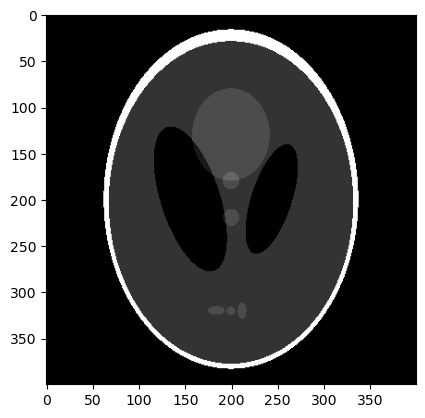

Dataset.file_meta -------------------------------
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.8.498.17429739403267925247050647911837053330
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.8.498.1
(0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.4.4'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.826.0.1.3680043.8.498.17429739403267925247050647911837053330
(0008, 0020) Study Date                          DA: '20250403'
(0008, 0060) Modality                            CS: 'MR'
(0010, 0010) Patient's

In [53]:
input_image = shepp_logan_phantom()

patient_data = {
    "PatientID" : "2345",
    "PatientName" : "Mre^r",
    "StudyDate" : "20250403",
    "ImageComments" : "asd"
}

saveDICOM('test.dcm', input_image, patient_data)

loadDICOM("test.dcm")

In [55]:
def calculate_pos(radius, angle, offset=0):
    angle_radians = np.radians(angle + offset)
    x = int(radius * np.cos(angle_radians) + radius)
    y = int(radius * np.sin(angle_radians) + radius)
    return x,y 

In [58]:
# Transformata Radon'a
def radon(image, radius, angle_range, alfa=1, detectors=360, prog=360):
    scans = int(prog / alfa)
    sinogram = np.zeros((scans, detectors))
    
    for i in range(scans):
        angle = alfa * i
        emitter_pos = calculate_pos(radius, angle)
        
        detectors_pos = []
        
        for j in range(detectors):
            offset = 180 - angle_range/2 + j*angle_range/(detectors - 1)
            detectors_pos.append(calculate_pos(radius, angle, offset))
            
        for j, detector_p in enumerate(detectors_pos):
            line = BresenhamLine(emitter_pos[0], emitter_pos[1], detector_p[0], detector_p[1])
            values = [image[y][x] for x, y in line if 0 <= y < image.shape[0] and 0 <= x < image.shape[1]]
            sinogram[i][j] = np.sum(values) / max(1, len(values))
        
    return sinogram



def inverseRadon(sinogram, radius, angle_range, alfa, detectors, emitter_range=360):
    scans = int(emitter_range / alfa)
    size = 2 * radius
    image = np.zeros((size, size))
    
    for i in range(scans):
        angle = alfa * i
        emitter_pos = calculate_pos(radius, angle)
        
        for j in range(detectors):
            offset = 180 - angle_range/2 + j * (angle_range / (detectors - 1))
            detector_pos = calculate_pos(radius, angle, offset)
            line = BresenhamLine(emitter_pos[0], emitter_pos[1], detector_pos[0], detector_pos[1])
            
            
            for x, y in line:
                if 0 <= x < size and 0 <= y < size:
                    image[y, x] += sinogram[i, j] / len(line)
                    
    image -= np.min(image)
    if np.max(image) != 0:
        image /= np.max(image)

    return image

C:\Users\dell\AppData\Local\Temp\ipykernel_19896\398759736.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  input_image_color = imageio.imread(image_path)


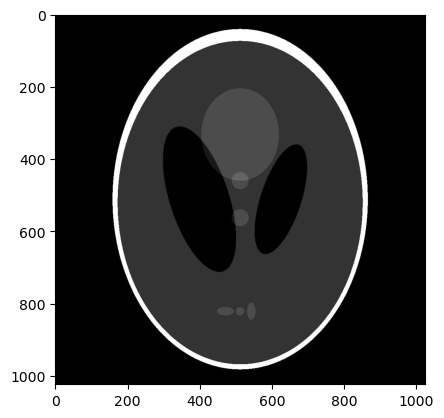

In [66]:
from skimage import color
import imageio

# Read zdjęcie i convert
image_path = 'zdj_tomog/Shepp_logan.jpg'

input_image_color = imageio.imread(image_path)
input_image = color.rgb2gray(input_image_color)
plt.imshow(input_image, cmap='gray')
input_image_height, input_image_width = input_image.shape
